# Pensacola Bay FL - Detailed step-by-step

## Standardize, clean and wrangle Water Quality Portal data in Pensacola and Perdido Bays into more analytic-ready formats using the harmonize_wq package


US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:

- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Pensacola and Perdido Bays

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
#!python -m pip install harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


#### Download location data using dataretrieval

<Axes: >

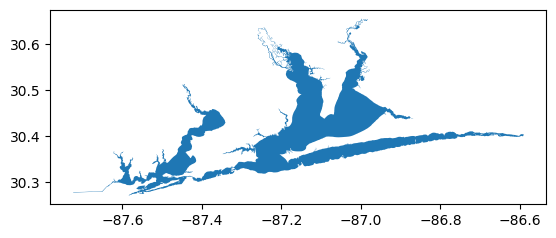

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://raw.githubusercontent.com/USEPA/harmonize-wq/main/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)  # already standard 4326
aoi_gdf.plot()

In [4]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf
# Spatial query parameters can be updated to run just one
bBox = wrangle.get_bounding_box(aoi_gdf)
# For only one bay, e.g., first is Pensacola Bay:
#bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [5]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [6]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [7]:
# Rows and columns for results
stations.shape

(2863, 37)

In [8]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107.0,27.8,sq mi,27.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-AL,USGS Alabama Water Science Center,USGS-02377570,"STYX RIVER NEAR ELSANOR, AL.",Stream,NaN,3140106.0,192.0,sq mi,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-AL,USGS Alabama Water Science Center,USGS-02377920,"BLACKWATER RIVER AT US HWY 90 NR ROBERTSDALE, AL.",Stream,NaN,3140106.0,23.1,sq mi,23.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-AL,USGS Alabama Water Science Center,USGS-02377960,"BLACKWATER RIVER AT CO RD 87 NEAR ELSANOR, AL.",Stream,NaN,3140106.0,56.6,sq mi,56.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-AL,USGS Alabama Water Science Center,USGS-02377975,BLACKWATER RIVER ABOVE SEMINOLE AL,Stream,NaN,3140106.0,40.2,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [9]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 30.498252
LongitudeMeasure                               -87.335809
Name: 0, dtype: object

In [10]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

In [11]:
location.harmonize_locations?

In [12]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(2863, 42)

In [13]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-87.3358086, 30.49825159)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-87.3358086 30.49825159)
geometry     POINT (-87.3358086 30.49825159)
Name: 0, dtype: object

In [14]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [15]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'}

<Axes: >

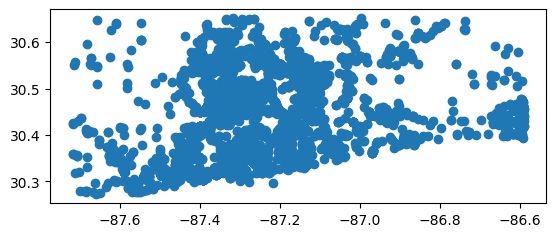

In [16]:
# Map it
stations_gdf.plot()

In [17]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

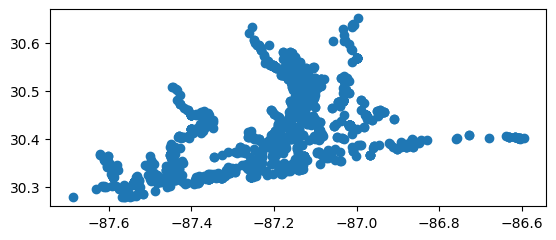

In [18]:
# Map it
stations_clipped.plot()

In [19]:
# How many stations now?
len(stations_clipped)

1419

In [20]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [21]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/dataretrieval/wqp.py:83: DtypeWarning: Columns (9,10,13,15,17,19,20,21,22,23,28,31,33,34,36,58,60,61,64,65,69,70,71,72,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=',')


In [22]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,2013-09-17,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,2013-07-23,10:01:00,EST,21FLPNS_WQX-33020146,STORET-308157908,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,2013-09-23,17:15:00,CST,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-028800618132,2013-06-18,11:01:00,EST,21FLSEAS_WQX-02SEAS880,STORET-310466105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1558337F1,2013-12-01,13:01:00,EST,21FLBFA_WQX-33020LT2,STORET-291224060,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418224,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900924,1959-02-04,NaN,NaN,USGS-303745086442101,NWIS-98928104,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
418225,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,CST,USGS-02376108,NWIS-6891392,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
418226,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,CST,USGS-02376108,NWIS-6891396,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
418227,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900926,1959-02-05,NaN,NaN,USGS-303820086241802,NWIS-6916678,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<Axes: >

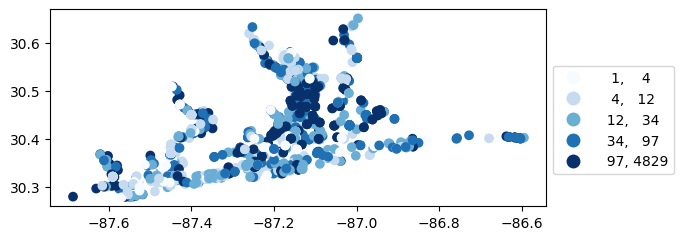

In [23]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [24]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

-Usable results-
count    14163.000000
mean         1.202973
std          2.345252
min          0.000000
25%          0.600000
50%          1.000000
75%          1.500000
max        260.000000
dtype: float64
Unusable results: 79
Usable results with inferred units: 0
Results outside threshold (0.0 to 15.274487417833242): 1


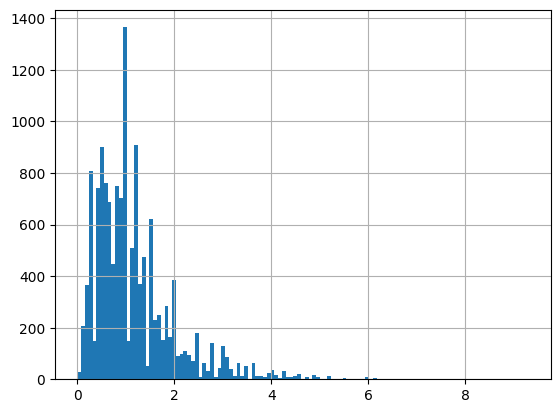

In [25]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [26]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
53,21FLPNS_WQX-33020JF1,0.60,m,NaN,m,0.6 meter
60,21FLGW_WQX-3565,.3,m,NaN,m,0.3 meter
64,21FLBFA_WQX-33010016,1.5,m,NaN,m,1.5 meter
107,21AWIC-7290,.94,m,NaN,m,0.94 meter
130,21FLBFA_WQX-33010030,1.25,m,NaN,m,1.25 meter
...,...,...,...,...,...,...
418109,21FLPNS_WQX-G5NW0034,0.9,m,NaN,m,0.9 meter
418121,21FLPNS_WQX-G4NW0508,1.3,m,NaN,m,1.3 meter
418129,21FLPNS_WQX-G4NW0531,0.67,m,NaN,m,0.67 meter
418142,21FLPNS_WQX-G4NW0009,1.1,m,NaN,m,1.1 meter


In [27]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
149215,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
149262,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
149631,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
149729,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
150850,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
406941,21FLKWAT_WQX-SAN-SKI WATCH-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
407058,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
407655,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
407663,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [28]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [29]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
149215,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
149262,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
149631,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
149729,21FLCBA_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
150850,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
406941,21FLKWAT_WQX-SAN-SKI WATCH-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
407058,21FLCBA_WQX-OKA-CBA-GAP-1-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
407655,21FLCBA_WQX-OKA-CB-BASS-2,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
407663,21FLCBA_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [30]:
# Aggregate Secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT01,12,2.333333
1,11NPSWRD_WQX-GUIS_CMP_PKT02,17,2.411765
2,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
3,21AWIC-1063,120,0.775167
4,21AWIC-1122,59,2.892102
...,...,...,...
1040,NARS_WQX-NCCA10-1432,1,1.075000
1041,NARS_WQX-NCCA10-1433,1,1.423333
1042,NARS_WQX-NCCA10-1434,1,2.400000
1043,NARS_WQX-NCCA10-1488,1,0.736667


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

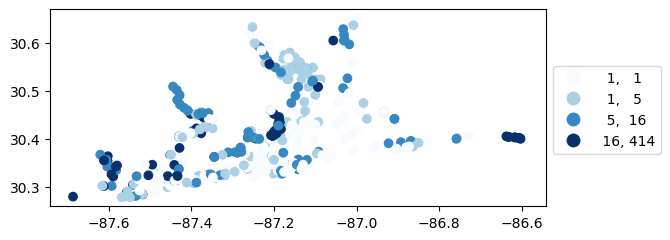

In [31]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

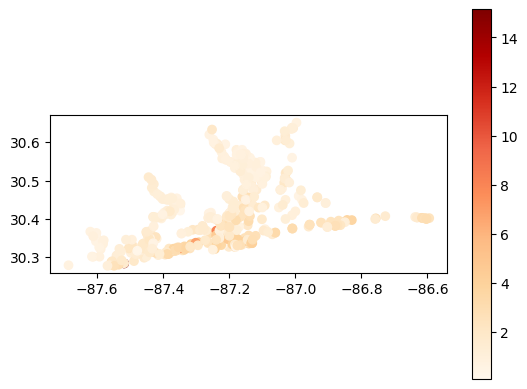

In [32]:
# Map average secchi depth results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    83690.000000
mean        21.955153
std         10.267861
min        -12.944444
25%         17.000000
50%         22.200000
75%         27.140000
max       1876.000000
dtype: float64
Unusable results: 2
Usable results with inferred units: 10
Results outside threshold (0.0 to 83.56231940773235): 6


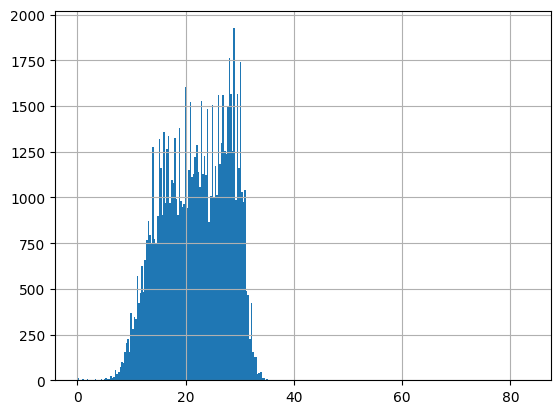

In [33]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [34]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLCBA_WQX-BAS02,78.9,deg F,NaN,26.0555555555556 degree_Celsius,degF
23,21FLPNS_WQX-33030019,23.12,deg C,NaN,23.12 degree_Celsius,degC
36,21FLPNS_WQX-330300G9,16.43,deg C,NaN,16.43 degree_Celsius,degC
38,21FLPNS_WQX-33010H24,29.78,deg C,NaN,29.78 degree_Celsius,degC
40,21FLPNS_WQX-33010G10,26.72,deg C,NaN,26.72 degree_Celsius,degC
...,...,...,...,...,...,...
418214,USGS-302420087140301,23.0,deg C,NaN,23.0 degree_Celsius,degC
418216,USGS-302703087133501,24.0,deg C,NaN,24.0 degree_Celsius,degC
418219,USGS-303733086441001,22.2,deg C,NaN,22.2 degree_Celsius,degC
418222,USGS-302703087133502,24.0,deg C,NaN,24.0 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [35]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
158197,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
223742,21FLCBA-FWB05,79.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.8 degree_Celsius,degC
223808,21FLCBA-FWB05,81.7,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",81.7 degree_Celsius,degC
224689,21FLCBA-FWB02,82.1,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.1 degree_Celsius,degC
224690,21FLCBA-FWB02,82.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.6 degree_Celsius,degC
224691,21FLCBA-FWB02,71.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.8 degree_Celsius,degC
224692,21FLCBA-FWB02,79.4,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.4 degree_Celsius,degC
230373,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
230374,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
235004,21FLCBA-FWB01,83.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",83.3 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [36]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [37]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
47448,11NPSWRD_WQX-GUIS_NALO,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
158197,NARS_WQX-OWW04440-0401,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [38]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,24.986667
1,11NPSWRD_WQX-GUIS_BCCA,1,36.800000
2,11NPSWRD_WQX-GUIS_BISA,32,22.696250
3,11NPSWRD_WQX-GUIS_BOPI,1,32.000000
4,11NPSWRD_WQX-GUIS_CMP_PKT01,20,25.125000
...,...,...,...
2469,UWFCEDB_WQX-SRC-AI31-22,10,23.020000
2470,UWFCEDB_WQX-SRC-AI36-22,10,23.230000
2471,UWFCEDB_WQX-SRC-AI42-22,10,22.650000
2472,UWFCEDB_WQX-SRC-AI44-22,10,22.890000


<Axes: >

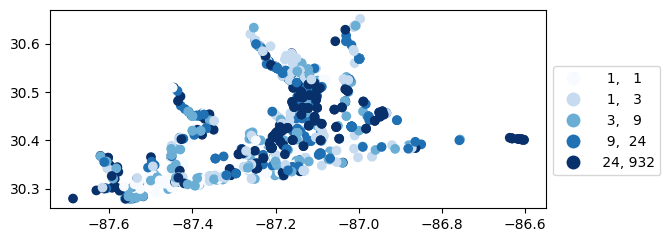

In [39]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

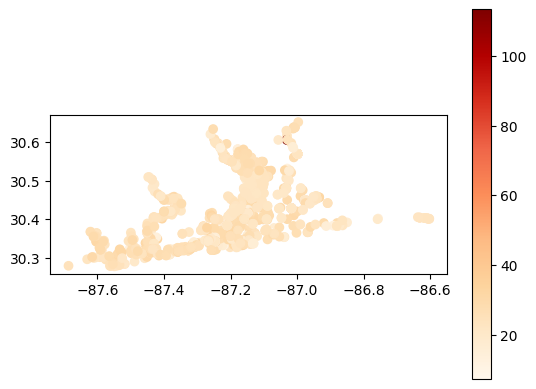

In [40]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [41]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [42]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
13,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
21,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
22,21FLPNS_WQX-33020K20,4.53,mg/L,NaN,4.53 milligram / liter
26,21FLPNS_WQX-33030019,9.32,mg/L,NaN,9.32 milligram / liter
...,...,...,...,...,...
418147,21FLPNS_WQX-G4NW0035,4.81,mg/L,NaN,4.81 milligram / liter
418151,21FLPNS_WQX-G5NW0007,4.4,mg/L,NaN,4.4 milligram / liter
418166,21FLPNS_WQX-G3NW0088,3.34,mg/L,NaN,3.34 milligram / liter
418175,21FLPNS_WQX-G4NW0063,0.48,mg/L,NaN,0.48 milligram / liter


In [43]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,21FLPNS_WQX-33030D71,6.64,mg/L,NaN,6.64 milligram / liter
13,21FLNUTT_WQX-PB02,8.11,mg/L,NaN,8.11 milligram / liter
21,21FLCBA_WQX-SRS03,6.28,mg/L,NaN,6.28 milligram / liter
22,21FLPNS_WQX-33020K20,4.53,mg/L,NaN,4.53 milligram / liter
26,21FLPNS_WQX-33030019,9.32,mg/L,NaN,9.32 milligram / liter
...,...,...,...,...,...
418147,21FLPNS_WQX-G4NW0035,4.81,mg/L,NaN,4.81 milligram / liter
418151,21FLPNS_WQX-G5NW0007,4.4,mg/L,NaN,4.4 milligram / liter
418166,21FLPNS_WQX-G3NW0088,3.34,mg/L,NaN,3.34 milligram / liter
418175,21FLPNS_WQX-G4NW0063,0.48,mg/L,NaN,0.48 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [44]:
# Aggregate DO data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,6.698000
1,11NPSWRD_WQX-GUIS_BCCA,1,0.270000
2,11NPSWRD_WQX-GUIS_BISA,32,7.194375
3,11NPSWRD_WQX-GUIS_BOPI,1,7.540000
4,11NPSWRD_WQX-GUIS_FPPO,1,9.950000
...,...,...,...
1999,UWFCEDB_WQX-SRC-AI31-22,20,3.723390
2000,UWFCEDB_WQX-SRC-AI36-22,20,3.513705
2001,UWFCEDB_WQX-SRC-AI42-22,20,3.677337
2002,UWFCEDB_WQX-SRC-AI44-22,20,3.658370


<Axes: >

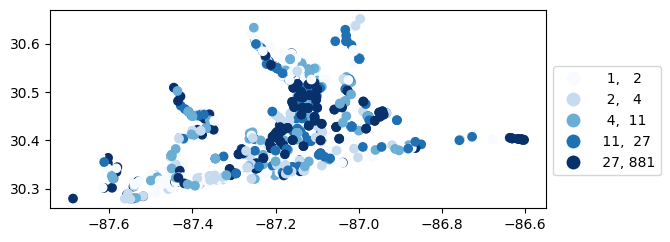

In [45]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

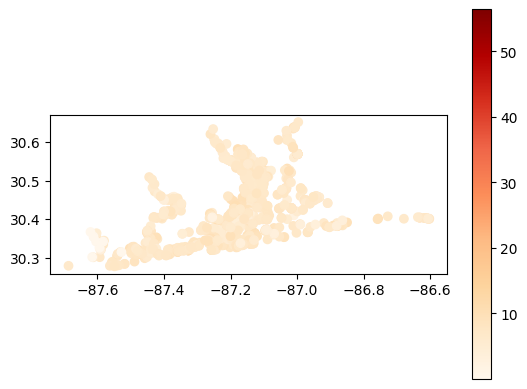

In [46]:
# Map Averages at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

-Usable results-
count    57379.000000
mean         7.341531
std          0.904435
min          0.500000
25%          6.860000
50%          7.680000
75%          8.000000
max         16.200000
dtype: float64
Unusable results: 51
Usable results with inferred units: 36
Results outside threshold (0.0 to 12.76814268989996): 1


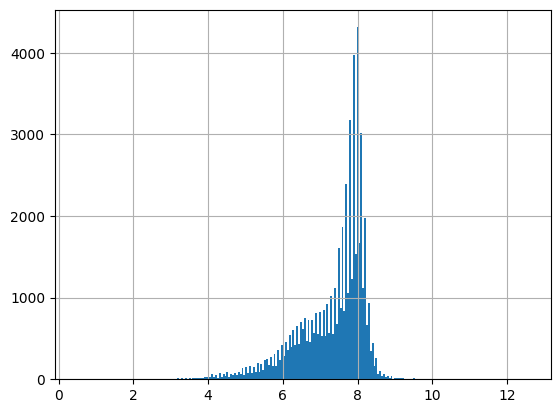

In [47]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [48]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
0,7.29,None,NaN,7.29 dimensionless
12,7.45,None,NaN,7.45 dimensionless
15,6.57,None,NaN,6.57 dimensionless
16,6.57,None,NaN,6.57 dimensionless
18,7.72,None,NaN,7.72 dimensionless
...,...,...,...,...
418223,5.9,std units,NaN,5.9 dimensionless
418224,7.9,std units,NaN,7.9 dimensionless
418226,8.3,std units,NaN,8.3 dimensionless
418227,6.6,std units,NaN,6.6 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

-Usable results-
count    71623.000000
mean        16.003990
std        152.637844
min          0.000000
25%          6.000000
50%         16.200000
75%         23.400000
max      37782.000000
dtype: float64
Unusable results: 417
Usable results with inferred units: 10
Results outside threshold (0.0 to 931.8310544495984): 4


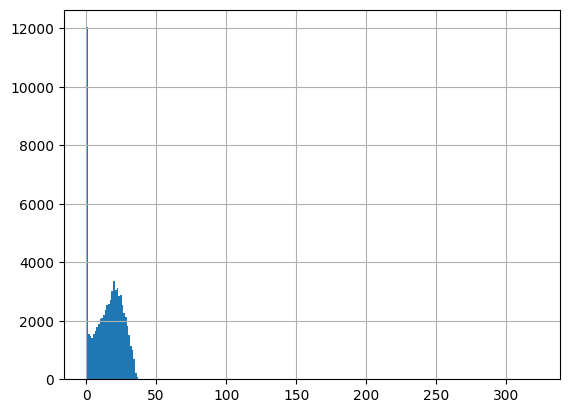

In [49]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True)

In [50]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
4,18.9,ppth,NaN,18.9 Practical_Salinity_Units
6,11.82,ppth,NaN,11.82 Practical_Salinity_Units
10,.03,ppt,NaN,0.03 Practical_Salinity_Units
17,0.50,ppth,NaN,0.5 Practical_Salinity_Units
19,3.3,ppth,NaN,3.3 Practical_Salinity_Units
...,...,...,...,...
418167,17.3,ppth,NaN,17.3 Practical_Salinity_Units
418173,0.03,ppth,NaN,0.03 Practical_Salinity_Units
418177,24.58,ppth,NaN,24.58 Practical_Salinity_Units
418179,17.59,ppth,NaN,17.59 Practical_Salinity_Units


###### Nitrogen

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)


-Usable results-
count     109.000000
mean       26.920174
std       160.257726
min         0.000700
25%         0.410000
50%         0.629000
75%         1.120000
max      1630.000000
dtype: float64
Unusable results: 4
Usable results with inferred units: 0
Results outside threshold (0.0 to 988.4665321860789): 1


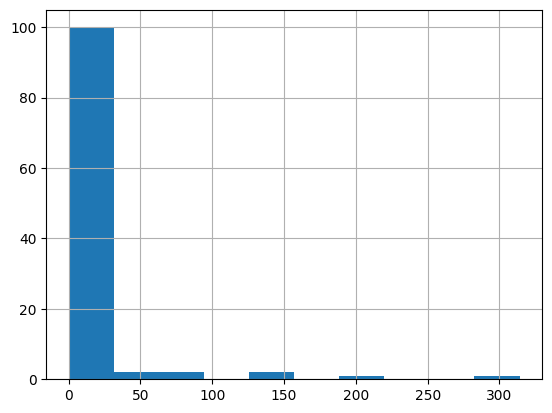

In [51]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [52]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
43125,0.3,mg/L,NaN,0.3 milligram / liter
43334,0.36,mg/L,NaN,0.36 milligram / liter
43483,0.33875,mg/L,NaN,0.33875 milligram / liter
43605,0.53125,mg/L,NaN,0.53125 milligram / liter
44139,135,mg/kg,NaN,135.00000000000003 milligram / liter
...,...,...,...,...
411485,18.69,mg/l,NaN,18.69 milligram / liter
411492,16.18,mg/l,NaN,16.18 milligram / liter
411493,18.99,mg/l,NaN,18.99 milligram / liter
411496,18.72,mg/l,NaN,18.72 milligram / liter


###### Conductivity

-Usable results-
count     1818.000000
mean     17085.221414
std      16116.889030
min          0.040000
25%        130.000000
50%      16994.750000
75%      30306.650000
max      54886.200000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 113786.55559242623): 0


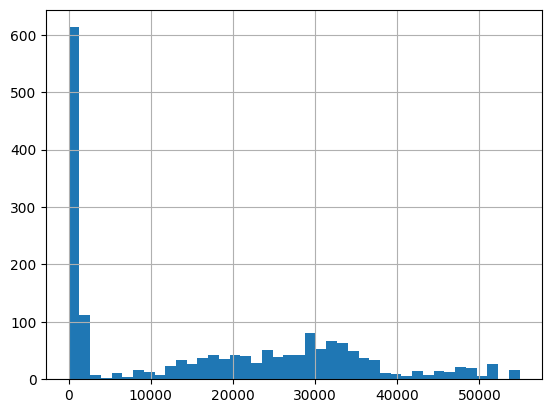

In [53]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [54]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
8,19204.2,umho/cm,NaN,19204.2 microsiemens / centimeter
50,222.3,umho/cm,NaN,222.3 microsiemens / centimeter
232,102.8,umho/cm,NaN,102.8 microsiemens / centimeter
394,11017.5,umho/cm,NaN,11017.5 microsiemens / centimeter
746,32,umho/cm,NaN,32.0 microsiemens / centimeter
...,...,...,...,...
415023,110,umho/cm,NaN,110.0 microsiemens / centimeter
415030,65,umho/cm,NaN,65.0 microsiemens / centimeter
415031,110,umho/cm,NaN,110.0 microsiemens / centimeter
415034,390,umho/cm,NaN,390.0 microsiemens / centimeter


###### Chlorophyll a

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/wq_data.py:395: UserWarning: WARNING: 'None' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)


-Usable results-
count    9266.000000
mean        1.169613
std         1.200140
min        -0.840000
25%         0.008300
50%         0.970000
75%         1.850000
max         9.990000
dtype: float64
Unusable results: 589
Usable results with inferred units: 0
Results outside threshold (0.0 to 8.370452978777962): 8


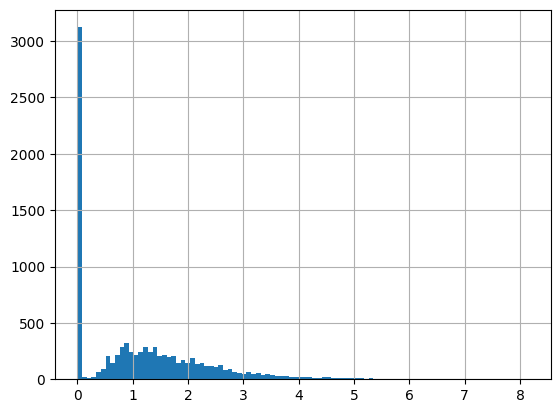

In [55]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [56]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
264,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
551,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
670,2.3,mg/m3,NaN,0.0023000000000000004 milligram / liter
1230,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
1370,2.9,mg/m3,NaN,0.0029000000000000007 milligram / liter
...,...,...,...,...
416567,1.1,mg/m3,NaN,0.0011000000000000003 milligram / liter
417159,4.4,mg/m3,NaN,0.004400000000000001 milligram / liter
417176,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
417730,1.1,mg/m3,NaN,0.0011000000000000003 milligram / liter


###### Organic Carbon

-Usable results-
count      4785.000000
mean       1148.065745
std       11639.036255
min           0.000000
25%           2.700000
50%           4.300000
75%           8.300000
max      410000.000000
dtype: float64
Unusable results: 165
Usable results with inferred units: 0
Results outside threshold (0.0 to 70982.2832722254): 22


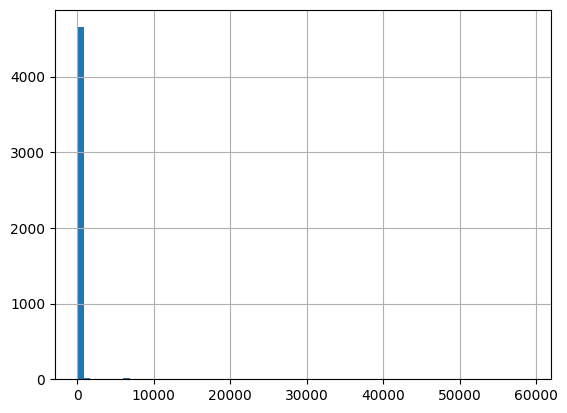

In [57]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [58]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
127,2.6,mg/L,NaN,2.6 milligram / liter
178,5.2,mg/L,NaN,5.2 milligram / liter
218,3.9,mg/L,NaN,3.9 milligram / liter
296,1.0,mg/L,NaN,1.0 milligram / liter
315,2.6,mg/L,NaN,2.6 milligram / liter
...,...,...,...,...
417961,5.5,mg/L,NaN,5.5 milligram / liter
418005,4.4,mg/L,NaN,4.4 milligram / liter
418029,5.647,mg/L,NaN,5.647 milligram / liter
418083,3.6,mg/L,NaN,3.6 milligram / liter


###### Turbidity

-Usable results-
count    40718.000000
mean         8.926798
std        203.564637
min         -0.840000
25%          1.420000
50%          2.590000
75%          4.900000
max      32342.452300
dtype: float64
Unusable results: 596
Usable results with inferred units: 10
Results outside threshold (0.0 to 1230.3146187462137): 45


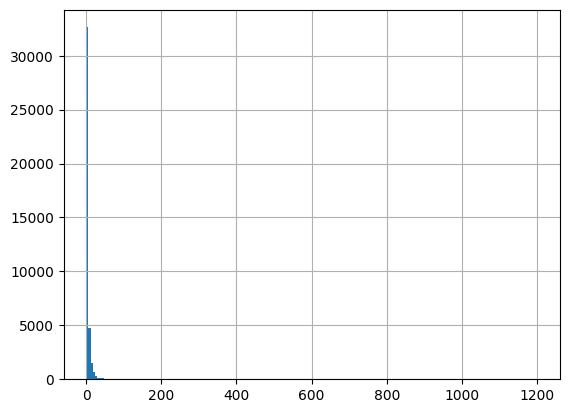

In [59]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True)

In [60]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
14,0,NTU,NaN,0.0 Nephelometric_Turbidity_Units
54,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
56,28,NTU,NaN,28.0 Nephelometric_Turbidity_Units
90,1.4,NTU,NaN,1.4 Nephelometric_Turbidity_Units
92,4.7,NTU,NaN,4.7 Nephelometric_Turbidity_Units
...,...,...,...,...
418116,1.57,NTU,NaN,1.57 Nephelometric_Turbidity_Units
418149,0.21,NTU,NaN,0.21 Nephelometric_Turbidity_Units
418153,39.0,NTU,NaN,39.0 Nephelometric_Turbidity_Units
418171,13.0,NTU,NaN,13.0 Nephelometric_Turbidity_Units


###### Sediment

In [61]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [63]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

2 Phosphorus sample fractions not in frac_dict
2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [64]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
20,.061,mg/L,NaN,NaN
96,0.03,mg/L,NaN,NaN
147,.13,mg/L,NaN,NaN
161,0.003,mg/L,NaN,NaN
360,0.002,mg/L,NaN,NaN
...,...,...,...,...
417926,0.223,mg/L,NaN,NaN
417951,0.032,mg/L,NaN,NaN
417985,0.046,mg/L,NaN,NaN
417999,0.007,mg/L,NaN,NaN


In [65]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
20,.061,mg/L,NaN,NaN
96,0.03,mg/L,NaN,NaN
147,.13,mg/L,NaN,NaN
161,0.003,mg/L,NaN,NaN
360,0.002,mg/L,NaN,NaN
...,...,...,...,...
417926,0.223,mg/L,NaN,NaN
417951,0.032,mg/L,NaN,NaN
417985,0.046,mg/L,NaN,NaN
417999,0.007,mg/L,NaN,NaN


In [66]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3657,0.019,mg/L,NaN,0.019 milligram / liter
8220,0.002,mg/L,NaN,0.002 milligram / liter
23204,0.003,mg/L,NaN,0.003 milligram / liter
26371,0.019,mg/L,NaN,0.019 milligram / liter
56262,0.002,mg/L,NaN,0.002 milligram / liter
58130,0.017,mg/L,NaN,0.017 milligram / liter
73542,0.020,mg/L,NaN,0.02 milligram / liter
79471,0.002,mg/L,NaN,0.002 milligram / liter
102000,0.021,mg/L,NaN,0.021 milligram / liter
104789,0.003,mg/L,NaN,0.003 milligram / liter


In [67]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
10308,.5,mg/L,NaN,NaN
10418,.036,mg/L,NaN,NaN
11746,.089,mg/L,NaN,NaN
12772,.017,mg/L,NaN,NaN
13875,.067,mg/L,NaN,NaN
...,...,...,...,...
414993,.18,mg/L,NaN,NaN
415004,.25,mg/L,NaN,NaN
415016,.16,mg/L,NaN,NaN
415019,.18,mg/L,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count    10035.000000
mean        45.537618
std        448.839329
min          0.000000
25%          4.000000
50%          8.000000
75%         33.000000
max      33000.000000
dtype: float64
Unusable results: 40571
Usable results with inferred units: 0
Results outside threshold (0.0 to 2738.5735941387825): 6


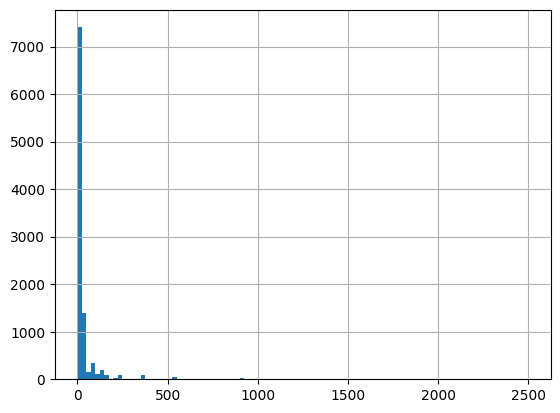

In [68]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
1,80,cfu/100mL,NaN,NaN
3,2,MPN/100mL,NaN,NaN
5,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
9,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
28,40,cfu/100mL,NaN,NaN
...,...,...,...,...
417623,180,cfu/100mL,NaN,NaN
417715,74,cfu/100mL,NaN,NaN
417717,2,cfu/100mL,NaN,NaN
417770,170,cfu/100mL,NaN,NaN


###### Escherichia coli

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


-Usable results-
count      22.000000
mean      501.863636
std       610.053260
min         4.000000
25%         9.500000
50%        77.500000
75%      1000.000000
max      1700.000000
dtype: float64
Unusable results: 8930
Usable results with inferred units: 0
Results outside threshold (0.0 to 4162.183198738116): 0


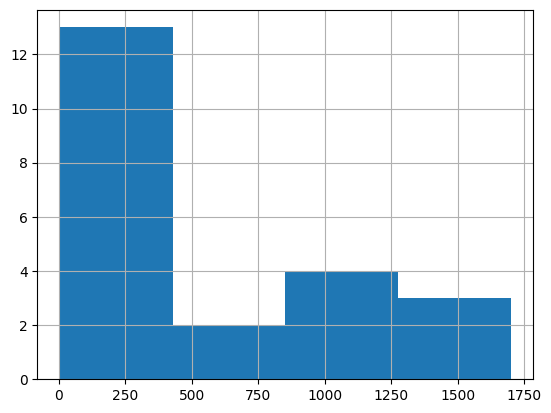

In [70]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [71]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
11,0,cfu/100mL,NaN,NaN
37,1000,cfu/100mL,NaN,NaN
45,0,cfu/100mL,NaN,NaN
99,33.3333333333333,cfu/100mL,NaN,NaN
136,0,cfu/100mL,NaN,NaN
...,...,...,...,...
417888,98.0,MPN/100mL,NaN,NaN
417944,20.0,MPN/100mL,NaN,NaN
418059,93.0,MPN/100mL,NaN,NaN
418112,63.0,MPN/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [72]:
from harmonize_wq import convert

In [73]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 71623 
Mean: 16.00398961506825 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[15030.0, 37782.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [75]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [76]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
21759,15030,ppt,NaN,15030.0 Practical_Salinity_Units
31215,322,ppth,NaN,322.0 Practical_Salinity_Units
42633,2150,ppth,NaN,2150.0 Practical_Salinity_Units
69537,37782,ppth,NaN,37782.0 Practical_Salinity_Units
143798,2190,ppt,NaN,2190.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [77]:
from harmonize_wq import wrangle

In [78]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

In [79]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
2209,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
3786,0.00,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
18920,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
27214,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
32610,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
417330,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
417341,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
417351,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
417482,0,PSS,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [80]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

8         19204.2 microsiemens / centimeter
50          222.3 microsiemens / centimeter
232         102.8 microsiemens / centimeter
394       11017.5 microsiemens / centimeter
746          32.0 microsiemens / centimeter
                        ...                
415023      110.0 microsiemens / centimeter
415030       65.0 microsiemens / centimeter
415031      110.0 microsiemens / centimeter
415034      390.0 microsiemens / centimeter
415037       65.0 microsiemens / centimeter
Name: Conductivity, Length: 1818, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [81]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
130304,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
133651,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
126949,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
132382,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
126348,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
87330,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
143924,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
51516,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
36855,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [82]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
130304,54886.2,umho/cm,NaN,NaN,54886.2 microsiemens / centimeter
133651,54871.3,umho/cm,NaN,NaN,54871.3 microsiemens / centimeter
126949,54860.6,umho/cm,NaN,NaN,54860.6 microsiemens / centimeter
132382,54859.3,umho/cm,NaN,NaN,54859.3 microsiemens / centimeter
126348,54850.8,umho/cm,NaN,NaN,54850.8 microsiemens / centimeter
...,...,...,...,...,...
87330,6.8,umho/cm,NaN,NaN,6.8 microsiemens / centimeter
143924,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
51516,2,umho/cm,NaN,NaN,2.0 microsiemens / centimeter
36855,1,umho/cm,NaN,NaN,1.0 microsiemens / centimeter


In [83]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

130304    36.356 dimensionless
133651    36.345 dimensionless
126949    36.338 dimensionless
132382    36.336 dimensionless
126348     36.33 dimensionless
                  ...         
87330      0.013 dimensionless
143924     0.012 dimensionless
51516      0.012 dimensionless
36855      0.012 dimensionless
145118     0.012 dimensionless
Name: Salinity, Length: 1818, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [84]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
130304,2007-08-09,12:15:00,CST
133651,2007-08-09,12:15:00,CST
126949,2007-08-09,12:15:00,CST
132382,2007-08-09,12:15:00,CST
126348,2007-08-09,12:15:00,CST
...,...,...,...
418224,1959-02-04,NaN,NaN
418225,1958-01-14,09:20:00,CST
418226,1958-01-14,09:20:00,CST
418227,1959-02-05,NaN,NaN


In [85]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

/opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/dataretrieval/utils.py:87: UserWarning: Warning: 35999 incomplete dates found, consider setting datetime_index to False.
  warnings.warn(


,ActivityStartDate,Activity_datetime
130304,2007-08-09,2007-08-09 18:15:00+00:00
133651,2007-08-09,2007-08-09 18:15:00+00:00
126949,2007-08-09,2007-08-09 18:15:00+00:00
132382,2007-08-09,2007-08-09 18:15:00+00:00
126348,2007-08-09,2007-08-09 18:15:00+00:00
...,...,...
418224,1959-02-04,NaT
418225,1958-01-14,1958-01-14 15:20:00+00:00
418226,1958-01-14,1958-01-14 15:20:00+00:00
418227,1959-02-05,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [86]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

1618       7.0
3651       7.0
88866      1.0
89336     16.0
89740     16.0
          ... 
111220     0.5
111304     1.3
111319     2.0
111346     2.2
143291    35.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 179, dtype: float64

#### Characteristic to Column (long to wide format)

In [87]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_Turbidity,QA_DO,QA_Carbon,QA_Chlorophyll,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Salinity,QA_pH,QA_Conductivity
130304,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383613,230231.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133651,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383607,230230.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126949,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383595,230228.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132382,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383601,230229.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126348,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,2007-08-09,12:15:00,-0600,21AWIC-1122,STORET-170383589,230227.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418224,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900924,1959-02-04,NaN,NaN,USGS-303745086442101,NWIS-98928104,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418225,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,-0600,USGS-02376108,NWIS-6891392,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418226,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,-0600,USGS-02376108,NWIS-6891396,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
418227,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900926,1959-02-05,NaN,NaN,USGS-303820086241802,NWIS-6916678,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [89]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

51690 fewer rows


In [90]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [91]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [92]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_Temperature', 'QA_E_coli',
       'QA_Fecal_Coliform', 'QA_Nitrogen', 'QA_Secchi', 'QA_Turbidity',
       'QA_DO', 'QA_Carbon', 'QA_Chlorophyll', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Salinity', 'QA_pH',
       'QA_Conductivity'],
      dtype='object')

In [93]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Turbidity,QA_DO,QA_Carbon,QA_Chlorophyll,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Salinity,QA_pH,QA_Conductivity
130304,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230231_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.356 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133651,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230230_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.345 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126949,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230228_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.338 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132382,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230229_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.336 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126348,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-51908_230227_173,21AWIC-1122,STORET,NaN,NaN,NaN,NaN,36.33 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_E_coli',
 'QA_Fecal_Coliform',
 'QA_Secchi',
 'QA_Carbon',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Conductivity']

<Axes: >

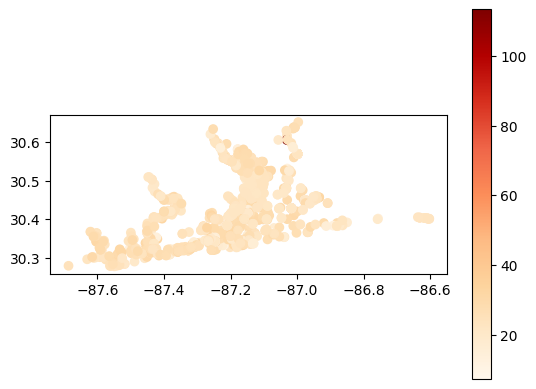

In [95]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)